In [228]:
import os
import cv2
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, silhouette_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

In this notebook, the classification task is investigated for the BigCats dataset.
Including a grid search, and a performance evaluation. 
All figures produced are saved in the directory figures/. 

In [201]:
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, data_directory, image_size=(256, 256)):
        self.data_directory = data_directory
        self.image_size = image_size
        
    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None, y=None):
        images = []
        labels = []
        # get image labels from the folder names
        class_labels = os.listdir(self.data_directory)
        class_labels.sort()
        # loop through the directory
        for label_idx, class_name in enumerate(class_labels):
            class_dir = os.path.join(self.data_directory, class_name)
            # wrong directory
            if not os.path.isdir(class_dir): 
                continue
            # loop through image files
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                # check for valid image to load
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    img = cv2.imread(file_path)
                    img_resized = cv2.resize(img, self.image_size)
                    if img is not None:
                        images.append(img_resized)  # Store the raw image
                        labels.append(label_idx)  # Store the label as index

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

In [169]:
class ImageTransform(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(128, 128), to_gray=True, normalize=True):
        self.image_size = image_size
        self.to_gray = to_gray
        self.normalize = normalize

    def set_params(self, **params):
        if 'image_size' in params:
            self.image_size = params['image_size']
        if 'to_gray' in params:
            self.to_gray = params['to_gray']
        if 'normalize' in params:
            self.normalize = params['normalize']
        return self

    def fit(self, X=None, y=None):
        return self

    def transform(self, X):
        transformed_images = []
        # preprocess
        for img in X:
            # resize
            if self.image_size:
                img = cv2.resize(img, self.image_size)
            # grayscale
            if self.to_gray:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # normalize
            if self.normalize:
                img = img / 255.0  # Normalize to [0,1]
            transformed_images.append(img)
        
        return np.array(transformed_images)

In [170]:
class SIFTFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=500):
        # use opencv SIFT
        self.sift = cv2.SIFT_create()
        self.max_features = max_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sift_features = []
        for img in X:
            # SIFT takes in uint8 format images
            img_uint8 = (img * 255).astype(np.uint8)
            kp, des = self.sift.detectAndCompute(img_uint8, None)
            # features found
            if des is not None:
                des_flattened = des.flatten()
                # descriptors exceed max features truncate
                if len(des_flattened) > self.max_features:
                    des_flattened = des_flattened[:self.max_features]
                # descriptors shorter pad to max features
                else: 
                    des_flattened = np.pad(des_flattened, (0, self.max_features - len(des_flattened)), 'constant')
            # no features found
            else:
                des_flattened = np.zeros(self.max_features)
            sift_features.append(des_flattened)
        return np.array(sift_features)

In [171]:
class FourierFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        fft_features = []
        for img in X:
            # fft
            f_transform = np.fft.fft2(img)
            # shift zero frequency to center
            f_shift = np.fft.fftshift(f_transform)
            magnitude_spectrum = 20 * np.log(np.abs(f_shift))
            fft_features.append(magnitude_spectrum.flatten())
        return np.array(fft_features)

In [172]:
class SVDReducer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=100):
        self.n_components = n_components
        self.svd = None

    def fit(self, X, y=None):
        n_components = min(self.n_components, X.shape[1]) # debug for actual reduction
        self.svd = TruncatedSVD(n_components=n_components)
        self.svd.fit(X)
        return self

    def transform(self, X):
        return self.svd.transform(X)

In [202]:
# set variable
data_directory = 'data/BigCats'
RANDOM_SEED = 192
# kNN neighbors
number_neighbor = 5
# SVD components
n_components = 200
image_side = 200
k_fold = 5

In [203]:
decision_tree = DecisionTreeClassifier(random_state=RANDOM_SEED)
naive_bayes = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=number_neighbor)
dbscan = DBSCAN(eps=0.5, min_samples=5)

In [204]:
# define the pipelines for different classification methods
sift_decision_tree_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))
])
sift_naive_bayes_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', GaussianNB())
])
sift_knn_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', KNeighborsClassifier(n_neighbors=number_neighbor))
])
fourier_decision_tree_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))
])

fourier_naive_bayes_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', GaussianNB())
])

fourier_knn_pipeline = Pipeline([
    ('transform', ImageTransform()), 
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', KNeighborsClassifier(n_neighbors=number_neighbor))
])


In [205]:
# data load and split
image_loader = ImageLoader(data_directory=data_directory)
images, labels = image_loader.fit_transform(None)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_SEED)

In [206]:
print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (132, 256, 256, 3)
Test Data Shape: (34, 256, 256, 3)


In [207]:
# grid parameters sift
param_grid_sift_decision_tree = {
    'transform__image_size': [(64, 64), (128, 128)],  # Vary image augmentation size
    'sift__max_features': [200, 300, 500],  # Varying max features for SIFT
    'svd__n_components': [70, 140, 200],  # Varying SVD components
    'classifier__max_depth': [3, 5, 7, None]  # Varying Decision Tree depth
}

param_grid_sift_knn = {
    'transform__image_size': [(64, 64), (128, 128)],  # Vary image augmentation size
    'sift__max_features': [200, 300, 500],  # Varying max features for SIFT
    'svd__n_components': [70, 140, 200],  # Varying SVD components
    'classifier__n_neighbors': [3, 5, 7]  # Varying k-neighbors for KNN
}

param_grid_naive_sift_bayes = {
    'transform__image_size': [(64, 64), (128, 128)],  # Vary image augmentation size
    'sift__max_features': [200, 300, 500],  # Varying max features for SIFT
    'svd__n_components': [100, 200, 300]  # Varying SVD components (no params for Naive Bayes)
}

# grid parameters Fourier
param_grid_fourier_decision_tree = {
    'transform__image_size': [(64, 64), (128, 128)],  # Vary image augmentation size
    'svd__n_components': [70, 140, 200],  # Varying SVD components
    'classifier__max_depth': [3, 5, 7, None]  # Varying Decision Tree depth
}

param_grid_fourier_knn = {
    'transform__image_size': [(64, 64), (128, 128)],  # Vary image augmentation size
    'svd__n_components': [70, 140, 200],  # Varying SVD components
    'classifier__n_neighbors': [3, 5, 7]  # Varying k-neighbors for KNN
}

param_grid_fourier_naive_bayes = {
    'transform__image_size': [(64, 64), (128, 128)],  # Vary image augmentation size
    'svd__n_components': [70, 140, 200] 
}


In [224]:
# to run grid search
def fit_with_grid(pipeline, param_grid, X_train, y_train, X_test, y_test, cv_values=[5,7]):
    best_models = {}
    for cv in cv_values:
        print(f"\nRunning Grid Search with {cv}-fold cross-validation:")
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        # print best model and cross validation accuracy
        print(f"Best Model with {cv}-fold CV: {best_model}")
        print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
        # test the best model with appropriate test set
        # best image size
        best_image_size = best_model.named_steps['transform'].image_size
        print(f"Best image size: {best_image_size}")
        # test
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='weighted')  # weighted average for class imbalance
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")
        # store the best model for each kfold
        best_models[cv] = {
            'best_image_size': best_image_size, 
            'best_model': best_model,
            'best_validation_score': best_score, 
            'test accuracy': test_accuracy, 
            'test f1 score': test_f1
        }
    return best_models


In [225]:

# SIFT + Decision Tree
print("\nFitting SIFT + Decision Tree: ")
best_sift_decision_tree = fit_with_grid(
    sift_decision_tree_pipeline, param_grid_sift_decision_tree, X_train, y_train, X_test, y_test
)

# SIFT + Naive Bayes
print("\nFitting SIFT + Naive Bayes: ")
best_sift_naive_bayes = fit_with_grid(
    sift_naive_bayes_pipeline, param_grid_naive_sift_bayes, X_train, y_train, X_test, y_test
)

# SIFT + KNN
print("\nFitting SIFT + KNN : ")
best_sift_knn = fit_with_grid(
    sift_knn_pipeline, param_grid_sift_knn, X_train, y_train, X_test, y_test
)

# Fourier + Decision Tree
print("\mFitting Fourier + Decision Tree: ")
best_fourier_decision_tree = fit_with_grid(
    fourier_decision_tree_pipeline, param_grid_fourier_decision_tree, X_train, y_train, X_test, y_test
)

# Fourier + Naive Bayes 
print("\nFitting Fourier + Naive Bayes: ")
best_fourier_naive_bayes = fit_with_grid(
    fourier_naive_bayes_pipeline, param_grid_fourier_naive_bayes, X_train, y_train, X_test, y_test
)

# Fourier + KNN
print("\nFitting Fourier + KNN: ")
best_fourier_knn = fit_with_grid(
    fourier_knn_pipeline, param_grid_fourier_knn, X_train, y_train, X_test, y_test
)


Fitting SIFT + Decision Tree: 

Running Grid Search with 5-fold cross-validation:
Best Model with 5-fold CV: Pipeline(steps=[('transform', ImageTransform()),
                ('sift', SIFTFeatureExtractor(max_features=200)),
                ('svd', SVDReducer(n_components=70)),
                ('classifier', DecisionTreeClassifier(random_state=192))])
Best Cross-Validation Accuracy: 0.3322
Best image size: (128, 128)
Test Accuracy: 0.2353
Test F1 Score: 0.2163

Running Grid Search with 7-fold cross-validation:
Best Model with 7-fold CV: Pipeline(steps=[('transform', ImageTransform()),
                ('sift', SIFTFeatureExtractor()),
                ('svd', SVDReducer(n_components=140)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=7, random_state=192))])
Best Cross-Validation Accuracy: 0.2744
Best image size: (128, 128)
Test Accuracy: 0.2353
Test F1 Score: 0.2179

Fitting SIFT + Naive Bayes: 

Running Grid Search with 5-fold cross-validation:
Best M

In [232]:
class_names = {0: 'Cheetah', 1: 'Jaguar', 2: 'Leopard', 3: 'Lion', 4: 'Tiger'}
# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=[class_names[i] for i in range(len(class_names))],
            yticklabels=[class_names[i] for i in range(len(class_names))])
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
    plt.savefig(f"figures/{model_name}(Best Model with {cv}-fold CV).pdf", format="pdf", bbox_inches='tight', pad_inches=0)
    plt.show()


Confusion Matrix for sift_decision_tree with 5-fold CV:


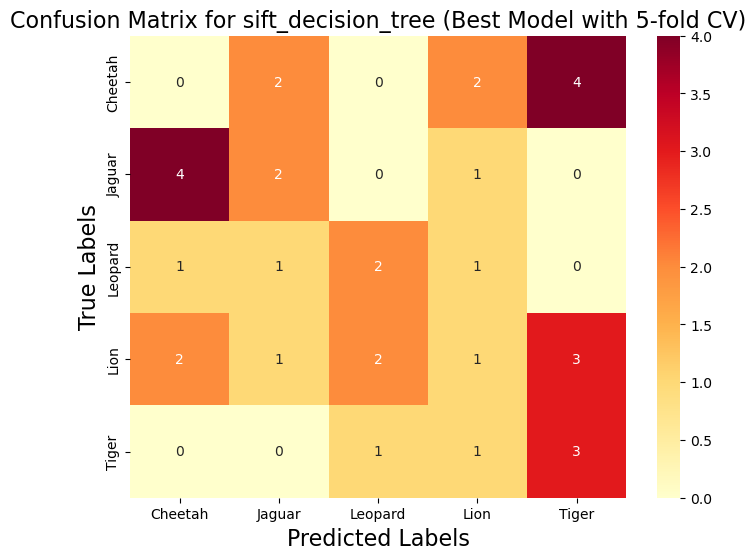


Confusion Matrix for sift_decision_tree with 7-fold CV:


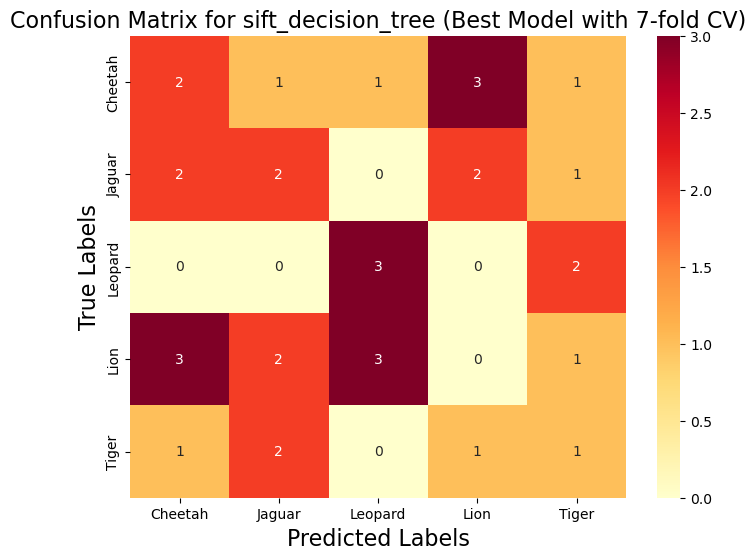


Confusion Matrix for sift_naive_bayes with 5-fold CV:


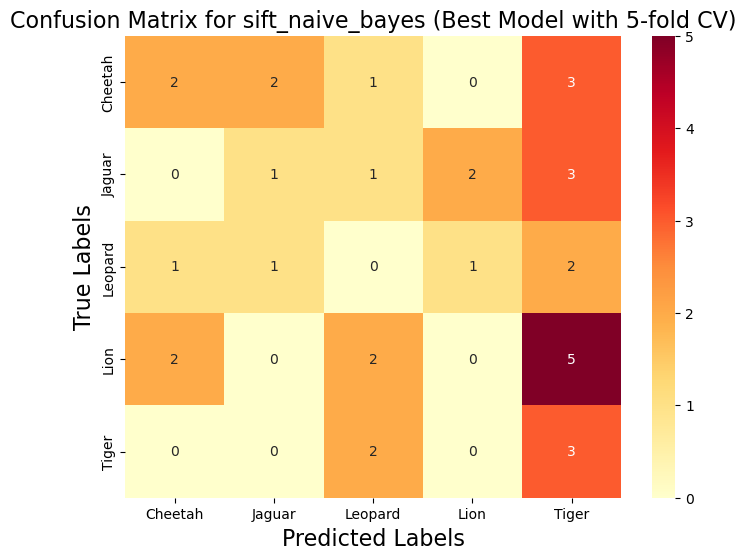


Confusion Matrix for sift_naive_bayes with 7-fold CV:


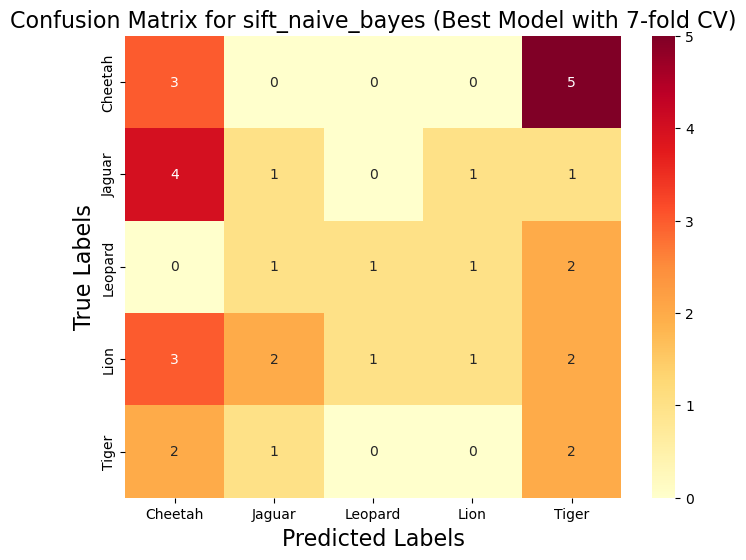


Confusion Matrix for sift_knn with 5-fold CV:


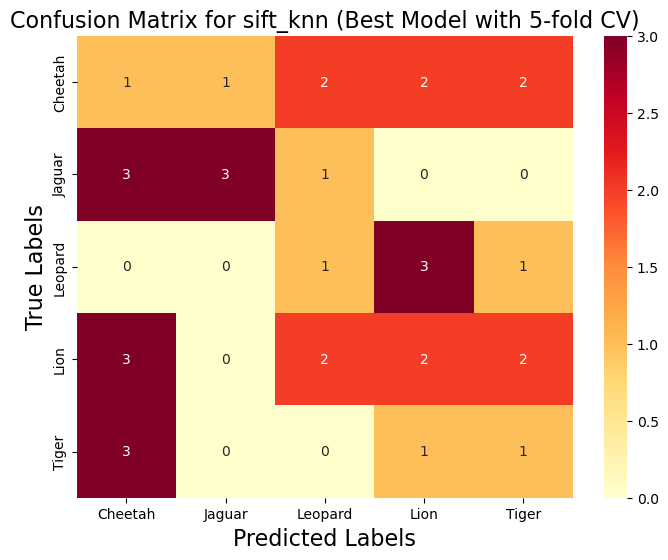


Confusion Matrix for sift_knn with 7-fold CV:


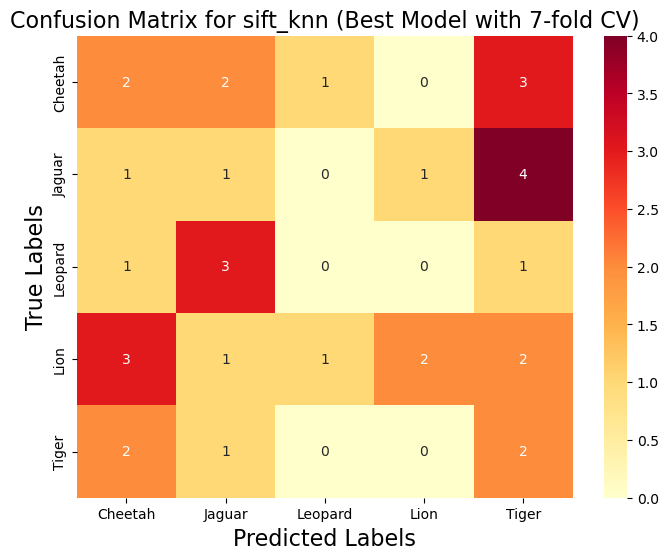


Confusion Matrix for fourier_decision_tree with 5-fold CV:


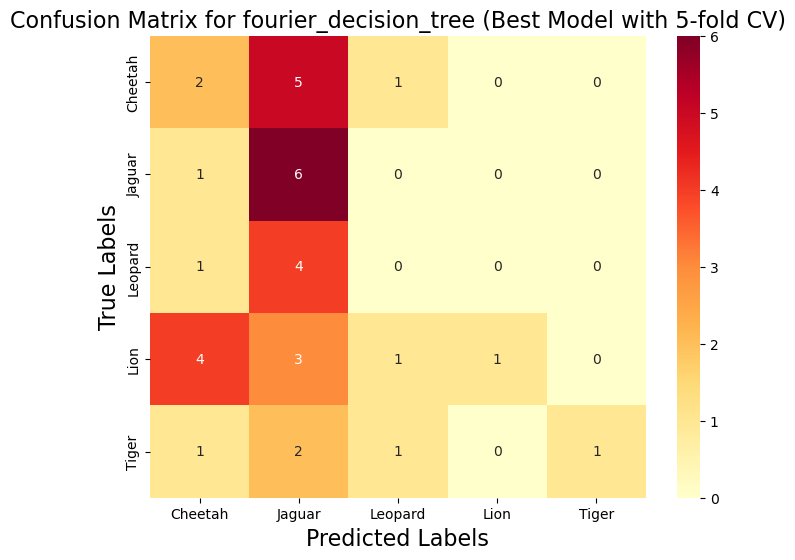


Confusion Matrix for fourier_decision_tree with 7-fold CV:


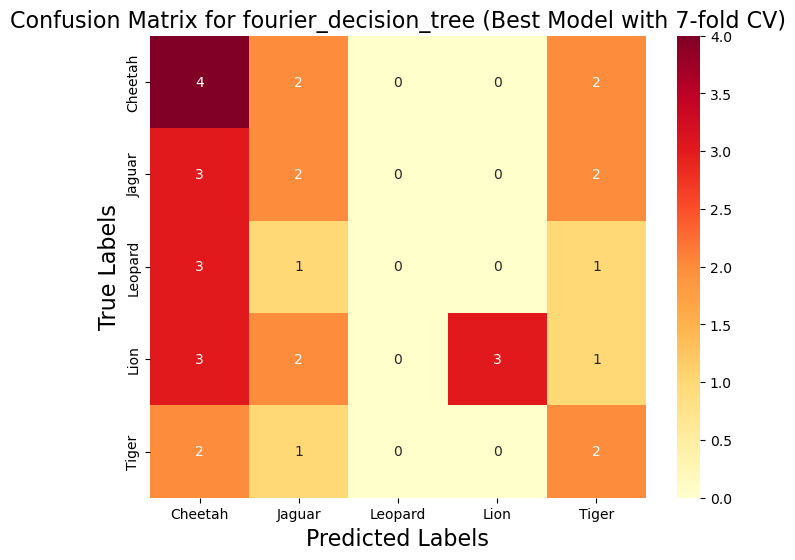


Confusion Matrix for fourier_naive_bayes with 5-fold CV:


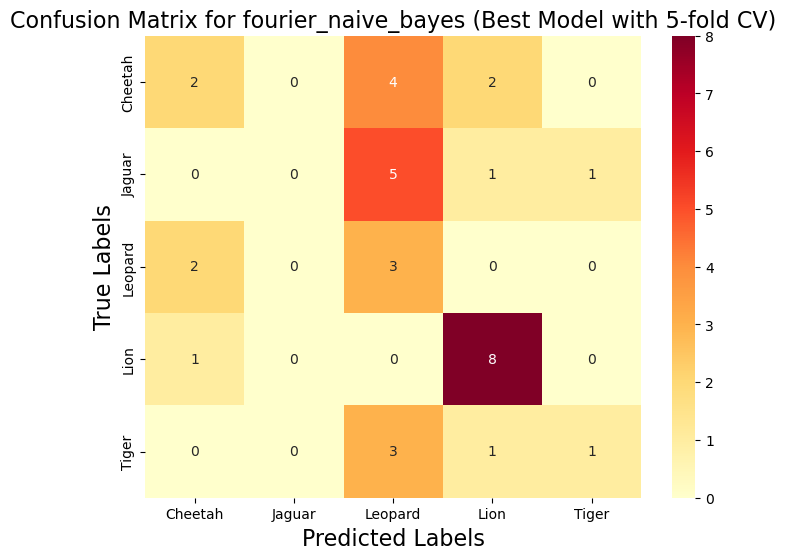


Confusion Matrix for fourier_naive_bayes with 7-fold CV:


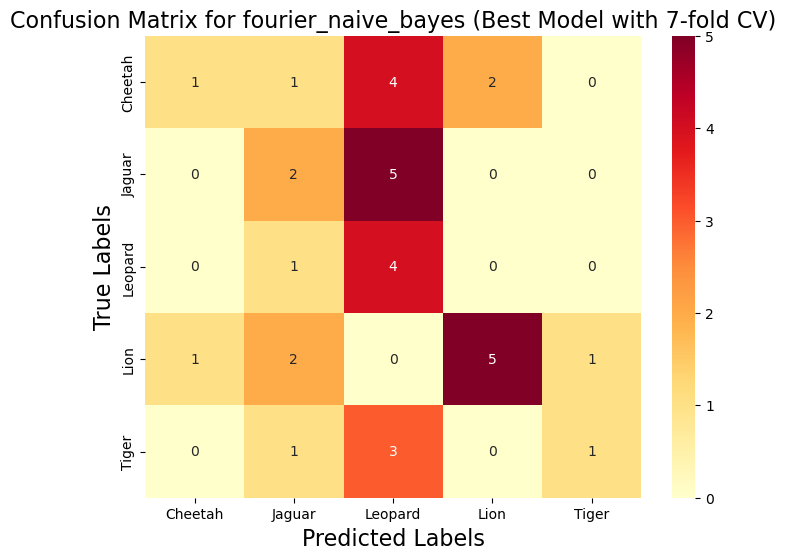


Confusion Matrix for fourier_knn with 5-fold CV:


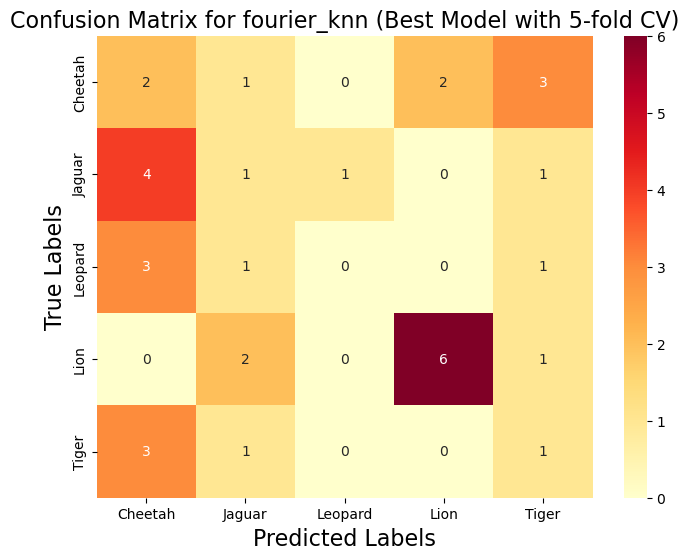


Confusion Matrix for fourier_knn with 7-fold CV:


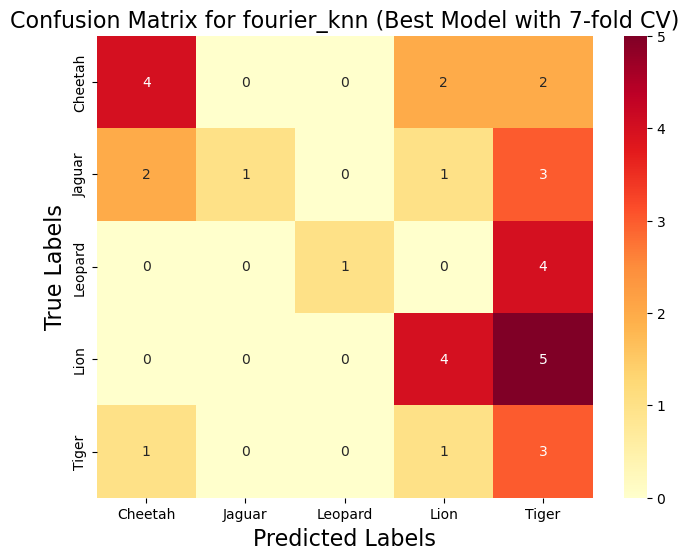

In [233]:
# confusion matrix for each best models
best_models = {}
best_models['sift_decision_tree'] = best_sift_decision_tree
best_models['sift_naive_bayes'] = best_sift_naive_bayes
best_models['sift_knn'] = best_sift_knn
best_models['fourier_decision_tree'] = best_fourier_decision_tree
best_models['fourier_naive_bayes'] = best_fourier_naive_bayes
best_models['fourier_knn'] = best_fourier_knn
for model_name, model_info in best_models.items():
    for cv, model_details in model_info.items():
        print(f"\nConfusion Matrix for {model_name} with {cv}-fold CV:")
        best_model = model_details['best_model']
        y_pred = best_model.predict(X_test)
        plot_confusion_matrix(y_test, y_pred, f"{model_name} (Best Model with {cv}-fold CV)")
        

In [231]:
# grid search for 80/20 validation
def grid_search_with_validation(pipeline, param_grid, X_train, y_train, X_val, y_val, X_test, y_test):
    best_score = 0
    best_params = None
    best_model = None

    # Iterate through each combination of parameters in the grid
    for params in ParameterGrid(param_grid):
        # Set the parameters in the pipeline
        pipeline.set_params(**params)
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Predict and evaluate on validation set
        y_pred = pipeline.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        
        # Track the best model based on F1 score
        if f1 > best_score:
            best_score = f1
            best_params = params
            best_model = pipeline
            
        print(f"Params: {params}")
        print(f"Validation Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    print("\nBest Model Parameters:", best_params)
    print("Best F1 Score on Validation Set:", best_score)
    
    # Evaluate the best model on the test set
    best_model.fit(X_train, y_train)  
    y_pred_test = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    print(f"\nTest Accuracy of Best Model: {test_accuracy:.4f}")
    print(f"Test F1 Score of Best Model: {test_f1:.4f}")
    
    return best_model, best_params, best_score, test_accuracy, test_f1

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)
best_model, best_params, best_f1_val, test_accuracy, test_f1 = grid_search_with_validation(
    sift_decision_tree_pipeline, 
    param_grid_sift_decision_tree, 
    X_train_split, 
    y_train_split, 
    X_val_split, 
    y_val_split, 
    X_test, 
    y_test
)

Params: {'classifier__max_depth': 3, 'sift__max_features': 200, 'svd__n_components': 70, 'transform__image_size': (64, 64)}
Validation Accuracy: 0.3704, F1 Score: 0.3059
Params: {'classifier__max_depth': 3, 'sift__max_features': 200, 'svd__n_components': 70, 'transform__image_size': (128, 128)}
Validation Accuracy: 0.1481, F1 Score: 0.1810
Params: {'classifier__max_depth': 3, 'sift__max_features': 200, 'svd__n_components': 140, 'transform__image_size': (64, 64)}
Validation Accuracy: 0.2222, F1 Score: 0.1992
Params: {'classifier__max_depth': 3, 'sift__max_features': 200, 'svd__n_components': 140, 'transform__image_size': (128, 128)}
Validation Accuracy: 0.1481, F1 Score: 0.1815
Params: {'classifier__max_depth': 3, 'sift__max_features': 200, 'svd__n_components': 200, 'transform__image_size': (64, 64)}
Validation Accuracy: 0.2222, F1 Score: 0.1992
Params: {'classifier__max_depth': 3, 'sift__max_features': 200, 'svd__n_components': 200, 'transform__image_size': (128, 128)}
Validation Accur

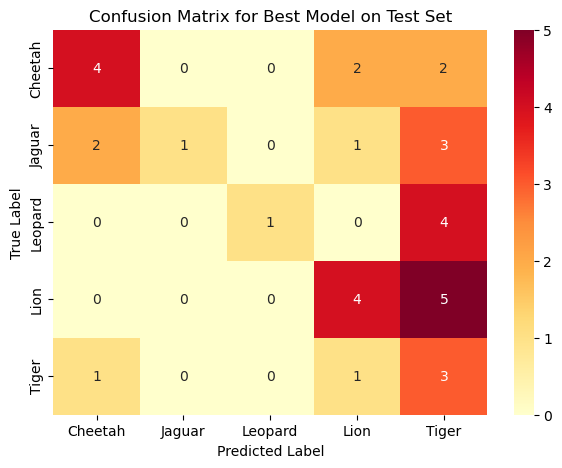

In [236]:
y_pred_test = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=[class_names[i] for i in range(len(class_names))],
            yticklabels=[class_names[i] for i in range(len(class_names))])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model on Test Set")
plt.savefig("figures/8020best_model_confusion_matrix.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()